In [64]:
# script to plot standard .las files
# most of the heavy lifting done with lasio and welly (github)


In [15]:
import welly
import lasio
import matplotlib.pyplot as plt
import numpy as np

In [23]:
datafile="204_30-1_DATACO_JWDL_QC.las" # want to loop over all *.las files in folder in the future

l = lasio.read(datafile)

z, gr, neutron, deepR = l['DEPTH'], l['GR'], l['NEUT'], l['RDEP'] # All wells will have this

selfp, microres, density, shalres, sp = l['SP'], l['RMIC'], l['DENS'], l['RSHAL'], l['SP']

# Don't pay attenton to the header error, these are fairly sparce headers (free UK gov .las)

Header section Parameter regexp=~P was not found.


In [24]:
well_name = l.well.WELL.value # grab well name from header, needed for plotting later


In [25]:
gr[-2000] # quick test

42.1477

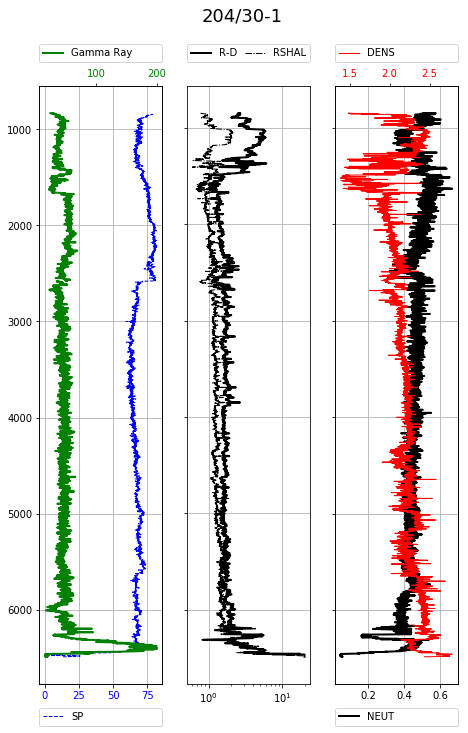

In [119]:
# Lets plot this bad boy
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.5,11))

# Gamma & SP
ax1.plot(sp, z, '--', lw=1, color='blue', label='SP')  # Spontaneous Potential
ax1.tick_params(axis='x', labelcolor='blue')
ax1.invert_yaxis()
ax1.grid(True)

# Lets do two axis ... one subplot
ax4 = ax1.twiny() # same y axis
ax4.plot(gr, z, lw=2, color='green', label='Gamma Ray') # Gamma Ray
ax4.tick_params(axis='x', labelcolor='Green')
# ax4.grid(True)

## subplot 1
ax1.legend( bbox_to_anchor=(0., -0.07, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax4.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

# legend
ax1.legend( bbox_to_anchor=(0., -0.07, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax4.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

# Resistivity
ax2.semilogx(deepR,z, lw=2, color='black', label='R-D') # Deep Induction Resistivity
ax2.semilogx(shalres, z,'-.', lw=1, color='black', label='RSHAL' ) # Spherically Focussed Log

ax2.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
ax2.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
ax2.invert_yaxis()
ax2.grid(True)


# Density and Porosity
ax3.plot(neutron, z, lw=2, color='black',label='NEUT') # Neutron Porosity
ax3.axes.yaxis.set_ticklabels([]) # get rid of y axis labels
ax3.invert_yaxis()
ax3.grid(True)

ax5 = ax3.twiny()
ax5.plot(density, z, lw=1, color='red', label='DENS') # Bulk Density
ax5.tick_params(axis='x', labelcolor='red')
# ax5.grid(True)

# legend
ax3.legend( bbox_to_anchor=(0., -0.07, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax5.legend(bbox_to_anchor=(0., 1.04, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)

## overall 
plt.suptitle(well_name, fontsize=18) # well name title

plt.savefig('foo.png', dpi=300) # save out to .png
plt.savefig('foo.svg', dpi=300) # save out to .svg
plt.savefig('foo.pdf', dpi=300) # save out to .svg

plt.show()

<bound method SubplotBase.label_outer of <matplotlib.axes._subplots.AxesSubplot object at 0x11808ceb8>>

plt.figure(figsize=(5,16))
plt.plot(gr, z, color='lightblue')
plt.plot(z, neutron, lw=3, color='red')
plt.plot(z, selfp, lw=1, color='black')
plt.show()